# Predictive Coding RNN

In [1]:
import torch
from torch import nn
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchvision

In this notebook, we demonstrate the PC-based learning algorithm for RNNs using the PC-RNN-HC-A model. We show how the model can be used for prediction and for inference.

In [2]:
class PC_RNN_HC_A(nn.Module):
    
    def __init__(self, causes_dim, states_dim, output_dim, tau_h, alpha_x, alpha_h):
        super(PC_RNN_HC_A, self).__init__()
        
        self.causes_dim = causes_dim
        self.output_dim = output_dim
        self.states_dim = states_dim
        self.tau_h = tau_h
        self.alpha_x = alpha_x
        self.alpha_h = alpha_h
        
        # Output weights initialization
        self.w_o = torch.randn(self.output_dim, self.states_dim) / self.states_dim
        self.b_o = torch.randn(self.output_dim) / 10
        
        # Recurrent weights initialization
        self.w_c = torch.randn(self.states_dim, self.causes_dim) / self.causes_dim
        self.w_r = torch.randn(self.states_dim, self.states_dim) / self.states_dim
        self.b_r = torch.randn(self.states_dim) / 10
        
        # Predictions, states and errors are temporarily stored for batch learning
        # Learning can be performed online, but computations are slower
        self.x_pred = None
        self.error = None
        self.h_prior = None
        self.h_post = None
        self.c = None
        
    def forward(self, x, c_init, h_init=0, store=True):
        """
        Pass through the network : forward (prediction) and backward (inference) passes are 
         performed at the same time. Online learning could be performed here, but to improve
         computations speed, we use the seq_len as a batch dimension in a separate function.
        Parameters :        
        - x : target sequences, Tensor of shape (seq_len, batch_size, output_dim)
        - h_init : states of the sequences, Tensor of shape (batch_size, states_dim)
        - store : whether to store the prediction as an object attribute, Boolean
        """

        seq_len, batch_size, _ = x.shape
        
        # Temporary storing of the predictions, states and errors
        if store:
            x_preds = torch.zeros(seq_len, batch_size, self.output_dim)
            h_priors = torch.zeros(seq_len, batch_size, self.states_dim)
            h_posts = torch.zeros(seq_len, batch_size, self.states_dim)
            cs = torch.zeros(seq_len, batch_size, self.causes_dim)
            error_hs = torch.zeros(seq_len, batch_size, self.states_dim)
        errors = torch.zeros(seq_len, batch_size, self.output_dim)
        
        # Initial hidden state and hidden causes
        old_h_post = h_init
        c = c_init
        
        for t in range(seq_len):
            
            # Top-down pass
            
            # Compute h_prior according to past h_post
            h_prior = (1-1/self.tau_h) * old_h_post + (1/self.tau_h) * (
                torch.mm(
                    torch.tanh(old_h_post),
                    self.w_r.T
                ) + \
                torch.mm(
                    c,
                    self.w_c.T
                ) + \
                self.b_r.unsqueeze(0).repeat(batch_size, 1)
            )
            if store:
                h_priors[t] = h_prior.detach()
            
            # Compute x_pred according to h_prior
            x_pred =  torch.mm(torch.tanh(h_prior), self.w_o.T) + self.b_o.unsqueeze(0).repeat(batch_size, 1)
            if store:
                x_preds[t] = x_pred.detach()
            
            # Compute the error on the sensory level
            error = x_pred - x[t]
            errors[t] = error
            
            # Bottom-up pass
            if self.alpha_x > 0:

                # Infer h_post according to h_prior and the error on the sensory level
                h_post = h_prior - self.alpha_x*(1-torch.tanh(h_prior)**2)*torch.mm(error, self.w_o)
                if store:
                    h_posts[t] = h_post.detach()

                # Compute the error on the hidden state level
                error_h = h_prior - h_post
                if store:
                    error_hs[t] = error_h.detach()

                # Infer c according to its past value and the error on the hidden state level
                c = c - self.alpha_h*torch.mm(error_h, self.w_c)
                if store:
                    cs[t] = c
                             
                old_h_post = h_post
            
            else:
                old_h_post = h_prior
                
        if store:
            self.error = errors.detach()
            self.x_pred = x_preds
            self.error_h = error_hs
            self.h_prior = h_priors
            self.h_post = h_posts
            self.c = cs
                             
        return errors
    
    def learn(self, lr_o, lr_h, lr_c):
        """
        Updating the model parameters based on the prediction error
        Parameters :        
        - lr_o : learning rate for the output weights
        - lr_h : learning rate for the recurrent weights
        - lr_c : learning rate for the causes to hidden weights
        """
        
        seq_len, batch_size, _ = self.x_pred.shape
        
        delta_w_o = torch.mm(
            self.error.reshape(seq_len*batch_size, self.output_dim).T, 
            torch.tanh(self.h_prior.reshape(seq_len*batch_size, self.states_dim))
        )
        self.w_o -= lr_o * delta_w_o
        
        delta_b_o = torch.sum(self.error.reshape(seq_len*batch_size, self.output_dim), axis=0)
        self.b_o -= lr_o * delta_b_o
        
        delta_w_c = torch.mm(
            self.error_h.reshape(seq_len*batch_size, self.states_dim).T,
            self.c.reshape(seq_len*batch_size, self.causes_dim)
        )
        self.w_c -= lr_c * delta_w_c
        
        delta_w_r = torch.mm(
            self.error_h[1:].reshape((seq_len-1)*batch_size, self.states_dim).T,
            torch.tanh(self.h_post[:-1].reshape((seq_len-1)*batch_size, self.states_dim))
        )
        self.w_r -= lr_h * delta_w_r
            
        delta_b_r = torch.sum(self.error_h.reshape(seq_len*batch_size, self.states_dim), axis=0)
        self.b_r -= lr_h * delta_b_r

    def vfe(self):
        """
        Computes the variational free-energy associated with the last seen values, up to a constant term
        """
        
        vfe = torch.zeros(2)  # We measure the contribution of each layer: X and H
        vfe[0] = 0.5 * torch.mean(torch.sum(self.error ** 2, axis=2)) * self.alpha_x
        vfe[1] = 0.5 * torch.mean(torch.sum(self.error_h ** 2, axis=2)) * self.alpha_h
        return vfe

We train this model on 3 sequence patterns from a data set of handwriting 2D trajectories.

torch.Size([60, 3, 2])


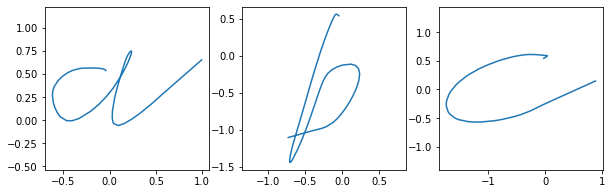

In [3]:
trajs = pk.load(open('handwriting_trajs_20.pk', 'rb'))
trajs = torch.Tensor(trajs.transpose(1, 0, 2)[:, :3]).float()
print(trajs.shape)

fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, 3)

axes[0].plot(trajs[:, 0, 0], trajs[:, 0, 1])
axes[0].axis('equal')
axes[1].plot(trajs[:, 1, 0], trajs[:, 1, 1])
axes[1].axis('equal')
axes[2].plot(trajs[:, 2, 0], trajs[:, 2, 1])
axes[2].axis('equal')

plt.show()

In [4]:
pcnet = PC_RNN_HC_A(3, 30, 2, 30, 0.001, 10)

h_init = torch.randn(1, pcnet.states_dim).repeat(3, 1)

iterations = 3000

vfes = torch.zeros(iterations, 2)
losses= torch.zeros(iterations)

for i in tqdm(range(iterations)):
    x_error = pcnet.forward(trajs, torch.eye(3), h_init)
    losses[i] = torch.mean(torch.sum(x_error**2, axis=1))
    vfes[i] = pcnet.vfe()
    pcnet.learn(0.002, 2, 2)

  0%|          | 0/3000 [00:00<?, ?it/s]

We can display the evolution of the VFE and the prediction error (L2 loss) during learning.

Additionally, we show the contribution of each layer of the network to the VFE:

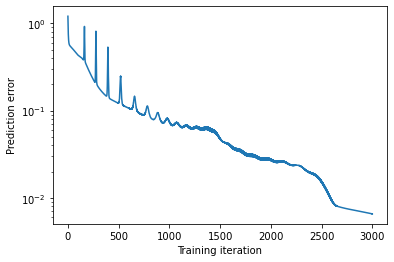

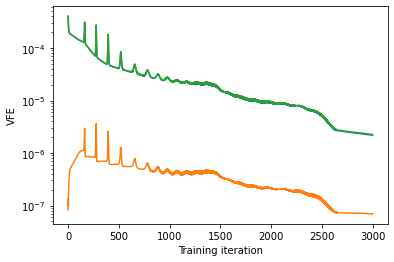

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(range(iterations), losses)
plt.yscale('log')
plt.xlabel('Training iteration')
plt.ylabel('Prediction error')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(iterations), vfes[:, 0])
plt.plot(range(iterations), vfes[:, 1])
plt.plot(range(iterations), torch.sum(vfes, axis=1))
plt.yscale('log')
plt.xlabel('Training iteration')
plt.ylabel('VFE')
plt.show()

## Using the network in prediction mode

After training, initializing the top layer of the network (the layer we called input in the code) with the one-hot values encoding the data set labels properly regenerates the target patterns.

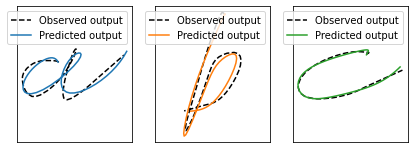

In [6]:
colors=['tab:blue', 'tab:orange', 'tab:green']
labels=['a', 'b', 'c']

tmp = pcnet.alpha_x
pcnet.alpha_x = 0.
pcnet.forward(torch.zeros(60, 3, 2), torch.eye(3), h_init)
pcnet.alpha_x = tmp

fig = plt.figure(figsize=(7, 2.5))
axes = fig.subplots(1, 3)

for k in range(3):
    axes[k].plot(trajs[:, k, 0], trajs[:, k, 1], '--', label='Observed output', c='black')
    axes[k].plot(pcnet.x_pred[:, k, 0], pcnet.x_pred[:, k, 1], label='Predicted output', c=colors[k])
    axes[k].axis('equal')
    axes[k].grid(False)
    axes[k].set_xticks([])
    axes[k].set_yticks([])
    axes[k].legend()
plt.show()

We can also display the evolution of the hidden state activation during prediction:

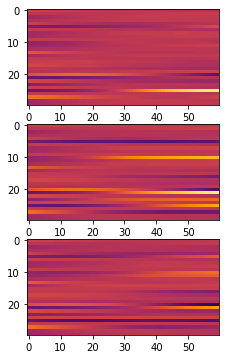

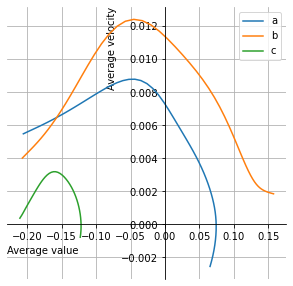

In [7]:
fig, axes = plt.subplots(3,1,figsize=(4,6))

for k in range(3):
    axes[k].imshow(pcnet.h_prior[:, k].T, cmap='inferno', vmin=-5, vmax=5)
    
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for k in range(3):
    ax.plot(torch.mean(pcnet.h_prior[:-1, k, :], axis=1), torch.mean(pcnet.h_prior[1:, k, :] - pcnet.h_prior[:-1, k, :], axis=1), c=colors[k], label=labels[k])

ax.grid(True, which='both')

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

ax.set_xlabel('Average value', loc='left')
ax.set_ylabel('Average velocity', loc='top')
ax.legend()
plt.show()

## Turning on the hidden state inference to dynamically correct the prediction

By using a value of $\alpha_x > 0$ and keeping $\alpha_h$ to 0, we correct the hidden state but don't update the hidden causes based on the prediction error signal. This can already improve the prediction accuracy, since the model can dynamically adjust the hidden state dynamics controlled by the recurrent weights, in order to decrease the prediction error on the output layer.

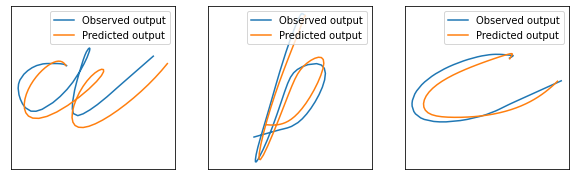

In [8]:
tmp = pcnet.alpha_x
tmp2= pcnet.alpha_h
pcnet.alpha_x = 0.005
pcnet.alpha_h = 0
pcnet.forward(torch.zeros(60, 3, 2), torch.eye(3), h_init)
pcnet.alpha_x = tmp
pcnet.alpha_h = tmp2

fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, 3)

for k in range(3):
    axes[k].plot(trajs[:, k, 0], trajs[:, k, 1], label='Observed output')
    axes[k].plot(pcnet.x_pred[:, k, 0], pcnet.x_pred[:, k, 1], label='Predicted output')
    axes[k].axis('equal')
    axes[k].grid(False)
    axes[k].set_xticks([])
    axes[k].set_yticks([])
    axes[k].legend()
plt.show()

This dynamic control process decrease the prediction error at time t, but this can also yield delayed effects making the prediction less precise in the next generation steps.

## Using the network in inference mode

After training, we can also perform classification with this model. We provide it with a neutral input, for instance [0.33, 0.33, 0.33], and one of the target patterns, here, the pattern "B". We reuse the inferred $c$ value as input for the next trial. After a few trials, the value of $c$ converges the correct label.

In [9]:
trials = 100

cs = torch.zeros(trials+1, 3)
cs[0] = torch.ones(3)/3 + torch.randn(3)/10

x_preds = torch.zeros(trials, 60, 2)
h_priors = torch.zeros(trials, 60, pcnet.states_dim)
vfes = torch.zeros(trials, 2)

pcnet.alpha_x=0.002
pcnet.alpha_h=1

for t in tqdm(range(trials)):
    pcnet.forward(trajs[:, 1:2], cs[t:t+1], h_init[0:1])
    cs[t+1] = pcnet.c[-1,0]
    x_preds[t] = pcnet.x_pred[:, 0]
    h_priors[t] = pcnet.h_prior[:, 0]
    vfes[t] = pcnet.vfe()

  0%|          | 0/100 [00:00<?, ?it/s]

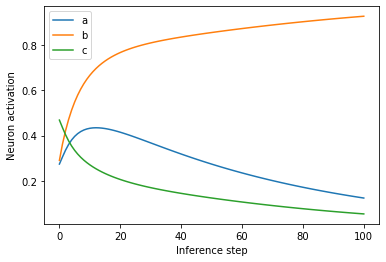

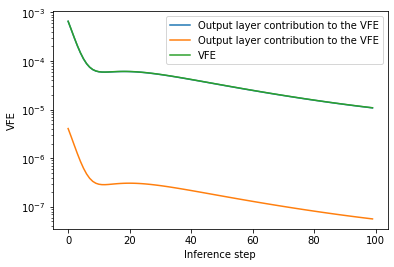

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(range(trials+1), cs[:, 0], label='a')
plt.plot(range(trials+1), cs[:, 1], label='b')
plt.plot(range(trials+1), cs[:, 2], label='c')
plt.xlabel('Inference step')
plt.ylabel('Neuron activation')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(trials), vfes[:, 0], label='Output layer contribution to the VFE')
plt.plot(range(trials), vfes[:, 1], label='Output layer contribution to the VFE')
plt.plot(range(trials), torch.sum(vfes, axis=1), label='VFE')
plt.yscale('log')
plt.xlabel('Inference step')
plt.ylabel('VFE')
plt.legend()
plt.show()

We can see in this example that the hidden causes converge towards a value in the neighborhood of the one-hot vector activated on the dimension $k$, where $k$ is the class of the target pattern, here, a "B". This inference process does not always work properly, and in fact often get stuck in local minima of VFE.

We can display the evolution of the model prediction through its different attempts at predicting the target sequence:

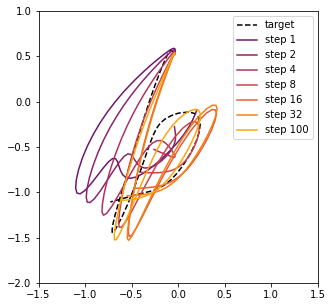

In [11]:
ks = [0, 1, 3, 7, 15, 31, 99]
category_colors = plt.get_cmap('inferno')(np.linspace(0.3, 0.8, len(ks)))

plt.figure(figsize=(5, 5))

plt.plot(trajs[:, 1, 0], trajs[:, 1, 1], '--', c='black', label='target')

for i, k in enumerate(ks):
    plt.plot(x_preds[k, :, 0], x_preds[k, :, 1], c=category_colors[i], label='step '+str(k+1))

plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-2, 1)

plt.show()

Additionnaly, we can represent the evolution of the prediction on the hidden layer throughout inference. This can be visualized in the phase space:

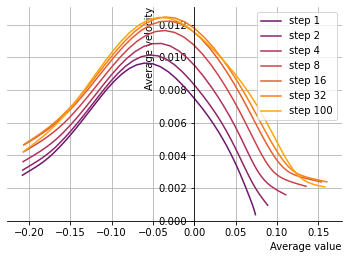

In [12]:
fig, ax = plt.subplots()

for i, k in enumerate(ks):
    ax.plot(torch.mean(h_priors[k, :-1], axis=1), torch.mean(h_priors[k, 1:] - h_priors[k, :-1], axis=1), c=category_colors[i], label='step '+str(k+1))

ax.grid(True, which='both')

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

ax.set_xlabel('Average value', loc='right')
ax.set_ylabel('Average velocity', loc='top')

ax.legend()
plt.show()

We can see that the hidden state dynamics evolve during the inference of the hidden causes